In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Load the dataset
file_path = 'COVID-19-Hospitals-Treatment-Plan.csv'
df = pd.read_csv(file_path)

# --- Data Cleaning and Preprocessing (no output) ---
df = df.drop(columns=['case_id', 'patientid'], errors='ignore')
df['Bed_Grade'] = df['Bed_Grade'].fillna(df['Bed_Grade'].mode()[0])
df['City_Code_Patient'] = df['City_Code_Patient'].fillna(df['City_Code_Patient'].mode()[0])

target = 'Stay_Days'
ordinal_features = ['Age', 'Illness_Severity']
nominal_features = ['Hospital', 'Hospital_type', 'Hospital_city',
                    'Hospital_region', 'Department', 'Ward_Type', 'Ward_Facility',
                    'Type_of_Admission', 'City_Code_Patient']

age_order = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']
severity_order = ['Minor', 'Moderate', 'Extreme']

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(categories=[age_order, severity_order]), ordinal_features),
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features)
    ],
    remainder='passthrough'
)

X = df.drop(target, axis=1)
y = df[target]

# --- Split Data (no output) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# --- Train and Evaluate the Model ---
print("\nTraining the XGBoost model...")
model = XGBClassifier(objective='multi:softprob', n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train_processed, y_train_encoded)
print("Model training complete!")

y_pred_encoded = model.predict(X_test_processed)
accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print(f"\nModel Accuracy: {accuracy:.4f}")




# --- Re-train the XGBoost Model by Controlling its Complexity ---
print("\nRe-training the XGBoost model with a controlled 'max_depth'...")

# The key change is adding 'max_depth=5'. This prevents the model from
# creating overly complex rules based on just one or two features.
constrained_model = XGBClassifier(
    objective='multi:softprob',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,  #  <-- THIS IS THE CRITICAL CHANGE
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Fit the new, more constrained model
constrained_model.fit(X_train_processed, y_train_encoded)
print("Constrained model training complete!")

# --- Evaluate the NEW Constrained Model ---
y_pred_constrained = constrained_model.predict(X_test_processed)
accuracy_constrained = accuracy_score(y_test_encoded, y_pred_constrained)

print(f"\nNew Model Accuracy (Constrained): {accuracy_constrained:.4f}")


Training the XGBoost model...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:09:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training complete!

Model Accuracy: 0.4226

Re-training the XGBoost model with a controlled 'max_depth'...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:10:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Constrained model training complete!

New Model Accuracy (Constrained): 0.4196


In [4]:
import pandas as pd
import sys

# (Assuming the model training part of the script has already been run,
# and the following objects exist: df, preprocessor, model, le)

# --- Dictionaries for Calculations ---
cost_schedule = {
    ('gynecology', 'Emergency'): 8000, ('gynecology', 'Trauma'): 7000, ('gynecology', 'Urgent'): 6500,
    ('radiotherapy', 'Emergency'): 15000, ('radiotherapy', 'Trauma'): 12000, ('radiotherapy', 'Urgent'): 10000,
    ('anesthesia', 'Emergency'): 11000, ('anesthesia', 'Trauma'): 9500, ('anesthesia', 'Urgent'): 8500,
    ('TB & Chest disease', 'Emergency'): 9000, ('TB & Chest disease', 'Trauma'): 7500, ('TB & Chest disease', 'Urgent'): 7000,
    ('surgery', 'Emergency'): 13000, ('surgery', 'Trauma'): 11000, ('surgery', 'Urgent'): 9000
}
stay_to_days_mapping = {
    '0-10': 5, '11-20': 15.5, '21-30': 25.5, '31-40': 35.5, '41-50': 45.5,
    '51-60': 55.5, '61-70': 65.5, '71-80': 75.5, '81-90': 85.5, '91-100': 95.5,
    'More than 100 Days': 110
}
administrative_day_rate = 2500

# --- Helper Functions ---
def get_patient_input_with_exit():
    """Prompts the user to select from a list of options and allows them to exit."""
    print("--- Please Enter New Patient Information (type 'quit' at any time to exit) ---")
    departments = ['gynecology', 'radiotherapy', 'anesthesia', 'TB & Chest disease', 'surgery']
    admission_types = ['Emergency', 'Trauma', 'Urgent']
    severity_levels = ['Minor', 'Moderate', 'Extreme']
    age_brackets = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

    def get_selection(prompt, options):
        for i, option in enumerate(options):
            print(f"{i + 1}: {option}")
        while True:
            choice_str = input(f"{prompt} (enter a number or 'quit'): ")
            if choice_str.lower() == 'quit': return None
            try:
                choice = int(choice_str) - 1
                if 0 <= choice < len(options): return options[choice]
                else: print("Invalid number. Please try again.")
            except ValueError:
                print("Invalid input. Please enter a number or 'quit'.")

    department = get_selection("\nSelect a Department", departments)
    if department is None: return None
    admission = get_selection("\nSelect an Admission Type", admission_types)
    if admission is None: return None
    severity = get_selection("\nSelect an Illness Severity", severity_levels)
    if severity is None: return None
    age = get_selection("\nSelect an Age Bracket", age_brackets)
    if age is None: return None

    visitors = int(input("\nEnter Number of Visitors: "))
    admission_deposit = float(input("Enter Admission Deposit amount: "))

    new_patient_data = {
        'Hospital': [8], 'Hospital_type': [2], 'Hospital_city': [3], 'Hospital_region': [2],
        'Available_Extra_Rooms_in_Hospital': [3], 'Department': [department], 'Ward_Type': ['R'],
        'Ward_Facility': ['F'], 'Bed_Grade': [2.0], 'City_Code_Patient': [7.0],
        'Type_of_Admission': [admission], 'Illness_Severity': [severity],
        'Patient_Visitors': [visitors], 'Age': [age], 'Admission_Deposit': [admission_deposit]
    }
    return pd.DataFrame(new_patient_data)

def calculate_administrative_delay_score(medical_cost, severity, admission_type, age):
    """Calculates a nuanced administrative delay based on a scoring system."""
    delay_score = 0
    if medical_cost > 200000: delay_score += 5
    elif medical_cost > 125000: delay_score += 3
    elif medical_cost > 75000: delay_score += 1
    if severity == 'Extreme': delay_score += 3
    elif severity == 'Moderate': delay_score += 1
    if admission_type == 'Emergency': delay_score += 2
    elif admission_type == 'Trauma': delay_score += 1
    if age in ['61-70', '71-80', '81-90', '91-100']: delay_score += 1
    return delay_score

# --- Main Prediction and Costing Workflow ---

new_patient_df = get_patient_input_with_exit()

if new_patient_df is None:
    print("\nExiting the program.")
else:
    # --- 1. Predict Medical Stay ---
    new_patient_processed = preprocessor.transform(new_patient_df)
    prediction_encoded = model.predict(new_patient_processed)
    predicted_stay_category = le.inverse_transform(prediction_encoded)[0]
    predicted_days = stay_to_days_mapping[predicted_stay_category]

    # --- 2. Calculate Medical Cost ---
    department = new_patient_df['Department'].iloc[0]
    admission_type = new_patient_df['Type_of_Admission'].iloc[0]
    lookup_key = (department, admission_type)
    daily_rate = cost_schedule.get(lookup_key, 6000)
    medical_cost = predicted_days * daily_rate

    # --- 3. Calculate Administrative Delay and Cost ---
    patient_severity = new_patient_df['Illness_Severity'].iloc[0]
    patient_age = new_patient_df['Age'].iloc[0]
    admin_delay_days = calculate_administrative_delay_score(medical_cost, patient_severity, admission_type, patient_age)
    administrative_cost = admin_delay_days * administrative_day_rate

    # --- 4. Calculate Final Totals ---
    total_stay_days = predicted_days + admin_delay_days
    total_final_cost = medical_cost + administrative_cost

    # --- 5. Display a Single, Consolidated Final Report ---
    print("\n\n==============================================")
    print("--- Final Patient Stay and Cost Report ---")
    print("==============================================")

    print("\n--- Medical Stay Prediction ---")
    print(f"Predicted Medical Stay: {predicted_stay_category} ({predicted_days} days)")
    print(f"Estimated Daily Rate:   ₹{daily_rate:,.2f}")
    print(f"Estimated Medical Cost: ₹{medical_cost:,.2f}")

    print("\n--- Administrative Delay Calculation ---")
    print("Based on the following factors:")
    print(f"Medical Cost:       ₹{medical_cost:,.2f}")
    print(f"Illness Severity:   {patient_severity}")
    print(f"Admission Type:     {admission_type}")
    print(f"Patient Age:        {patient_age}")
    print(f"Simulated Admin Delay:  {admin_delay_days} days")
    print(f"Administrative Cost:    ₹{administrative_cost:,.2f}")

    print("\n--- FINAL SUMMARY ---")
    print(f"Total Estimated Stay:   {total_stay_days} days")
    print(f"Total Estimated Cost:   ₹{total_final_cost:,.2f}")
    print("==============================================")



--- Please Enter New Patient Information (type 'quit' at any time to exit) ---
1: gynecology
2: radiotherapy
3: anesthesia
4: TB & Chest disease
5: surgery

Select a Department (enter a number or 'quit'): 1
1: Emergency
2: Trauma
3: Urgent

Select an Admission Type (enter a number or 'quit'): 1
1: Minor
2: Moderate
3: Extreme

Select an Illness Severity (enter a number or 'quit'): 2
1: 0-10
2: 11-20
3: 21-30
4: 31-40
5: 41-50
6: 51-60
7: 61-70
8: 71-80
9: 81-90
10: 91-100

Select an Age Bracket (enter a number or 'quit'): 67
Invalid number. Please try again.

Select an Age Bracket (enter a number or 'quit'): 3

Enter Number of Visitors: 2
Enter Admission Deposit amount: 5757


--- Final Patient Stay and Cost Report ---

--- Medical Stay Prediction ---
Predicted Medical Stay: 21-30 (25.5 days)
Estimated Daily Rate:   ₹8,000.00
Estimated Medical Cost: ₹204,000.00

--- Administrative Delay Calculation ---
Based on the following factors:
Medical Cost:       ₹204,000.00
Illness Severity:   

--- Distribution of Stay_Days Categories ---
Stay_Days
21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: count, dtype: int64


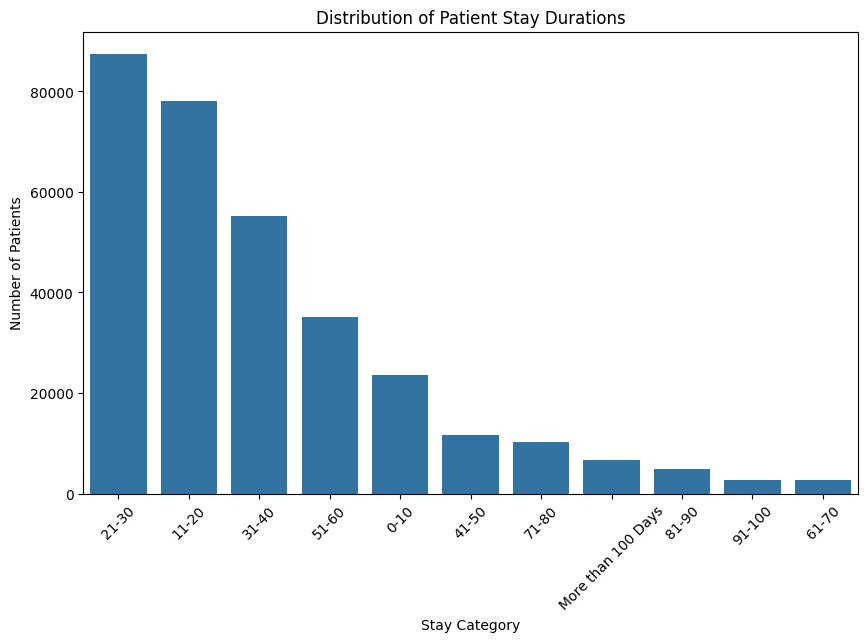

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Check the distribution of the target variable ---
print("--- Distribution of Stay_Days Categories ---")
print(df['Stay_Days'].value_counts())

# --- Visualize the imbalance ---
plt.figure(figsize=(10, 6))
sns.countplot(x='Stay_Days', data=df, order=df['Stay_Days'].value_counts().index)
plt.title('Distribution of Patient Stay Durations')
plt.xlabel('Stay Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.show()